In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
from windrose import WindroseAxes
import seaborn as sns

In [2]:
# netCDF files
fn1='C:\\Users\\odemeo\\Documents\\Field_Data_Processing\\CACO_MET\\Marconi\\1128\\1128wxt-a.nc'
fn2='C:\\Users\\odemeo\\Documents\\Field_Data_Processing\\CACO_MET\\Marconi\\1129A\\1129Awxt-a.nc'

In [4]:
# Read in mooring 1128
ds_1128 = xr.open_dataset(fn1)
ds_1128 # Marconi data when met was on solar panel
df_1128=ds_1128.to_dataframe() # Convert xarray dataset to pandas dataframe

# Make statistics table
df_1128.describe()

,WD_min,WD_410,WD_gust,WS_min,WS_401,WG_402,T_21,RH_910
count,43863.000000,43863.000000,43863.000000,43863.000000,43863.000000,43863.000000,43863.000000,43862.000000
mean,155.713089,205.439941,255.648956,1.521414,3.711896,6.129526,11.487256,68.965714
std,71.933113,85.489876,57.762169,0.907080,1.777657,3.039102,3.922698,20.598467
min,0.540000,0.540000,2.540000,0.000000,0.100000,0.300000,1.100000,20.799999
25%,97.540001,156.539993,232.539993,0.800000,2.400000,3.800000,8.500000,53.099998
50%,174.539993,220.539993,261.540009,1.500000,3.500000,5.500000,11.000000,68.900002
75%,197.539993,254.539993,299.540009,2.100000,4.700000,7.800000,14.300000,85.800003
max,359.540009,359.540009,359.540009,6.900000,12.600000,17.700001,25.900000,100.000000


In [5]:
# Put 1128 variables into arrays
time1128=ds_1128['time'].values
wdir_min1128=ds_1128['WD_min'].values
wdir_mean1128=ds_1128['WD_410'].values
wdir_max1128=ds_1128['WD_gust'].values
wsp_min1128=ds_1128['WS_min'].values
wsp_mean1128=ds_1128['WS_401'].values
wsp_max1128=ds_1128['WG_402'].values
temp1128=ds_1128['T_21'].values
relh1128=ds_1128['RH_910'].values

Text(0, 0.5, 'Rel. humidity (%)')

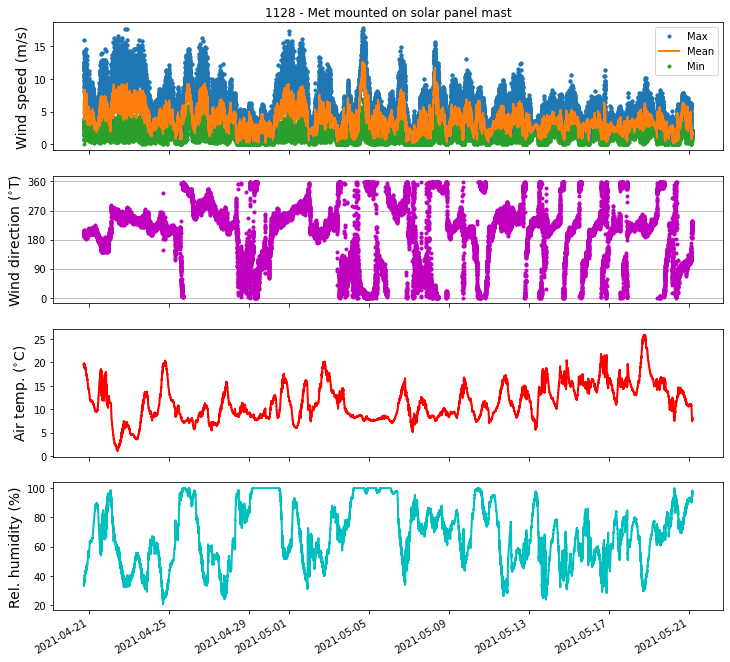

In [6]:
# 1128 Time-series plots
fig, ax=plt.subplots(nrows=4, ncols=1, sharey=False, sharex=True, squeeze=True, figsize = (12,12))

# Wind speed
ax[0].plot(time1128,wsp_max1128, '.',zorder=1,label='Max')
ax[0].plot(time1128,wsp_mean1128,'-',linewidth=2,zorder=2,label='Mean')
ax[0].plot(time1128,wsp_min1128, '.',zorder=0,label='Min')
ax[0].set_ylabel('Wind speed (m/s)',fontsize=14)
ax[0].legend()
ax[0].title.set_text('1128 - Met mounted on solar panel mast')
fig.autofmt_xdate() # Rotate x-axis labels so you can read all of them
#ax[0].text(.02,.85,'Wind speed',fontsize=16,transform=ax[0].transAxes)

# Wind direction
ax[1].plot(time1128,wdir_mean1128,'m.',linewidth=2)
ax[1].set_yticks([0.,90.,180.,270,360])
ax[1].set_ylabel('Wind direction ($^{\circ}$T)',fontsize=14)
ax[1].grid(axis = 'y')
#ax[1].text(.02,.85,'Wind direction (from)',fontsize=16,transform=ax[1].transAxes)

# Temp
ax[2].plot(time1128,temp1128,'r-',linewidth=2)
ax[2].set_ylabel('Air temp. ($^{\circ}$C)',fontsize=14)
#ax[2].text(.02,.1,'Air temperature',fontsize=16,transform=ax[2].transAxes)

# Relative humidity
ax[3].plot(time1128,relh1128,'c-',linewidth=2)
ax[3].set_ylabel('Rel. humidity (%)',fontsize=14)
#ax[3].text(.02,.1,'Relative humidity',fontsize=16,transform=ax[4].transAxes)


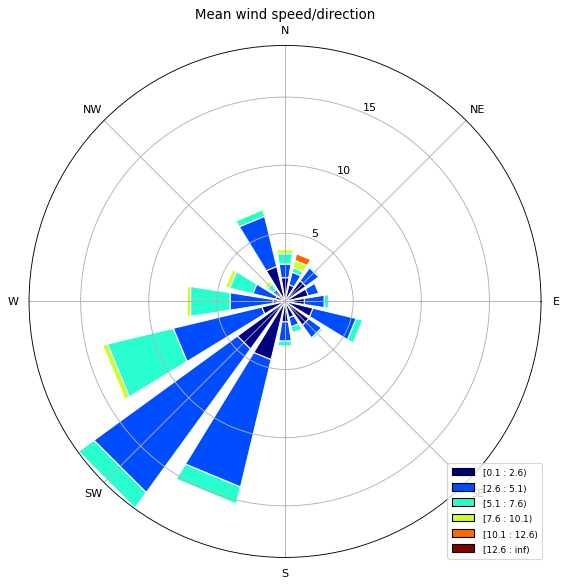

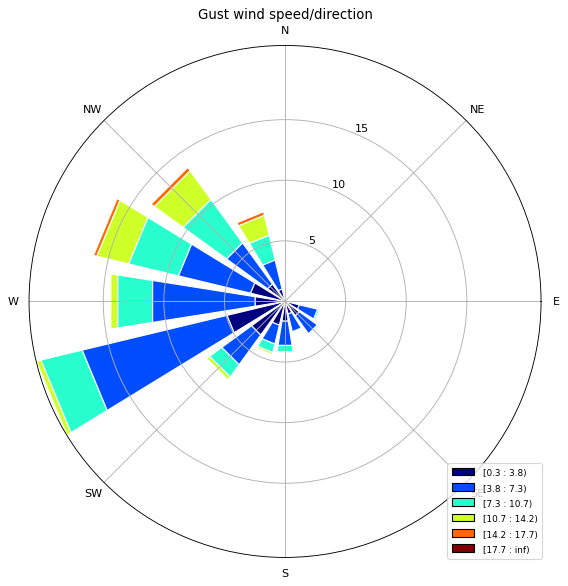

In [7]:
# 1128 Wind rose plot

# Mean wind dir/sp
ax=WindroseAxes.from_ax()
ax.bar(wdir_mean1128, wsp_mean1128, normed=True, opening=0.8, edgecolor='white')
ax.set_legend(loc=4)
plt.title('Mean wind speed/direction')
ax.set_yticks(np.arange(5, 20, step=5))
ax.set_yticklabels(np.arange(5, 20, step=5))
#ax.set_xticklabels((90, 45, 0, 315, 270, 225, 180, 135)) # Add this line bc there is an error in windrose axes
ax.set_xticklabels(['E', 'NE','N', 'NW', 'W', 'SW', 'S', 'SE']); # Add this line bc there is an error in windrose axes

# Gust wind dir/sp
ax=WindroseAxes.from_ax()
ax.bar(wdir_max1128, wsp_max1128, normed=True, opening=0.8, edgecolor='white')
ax.set_legend(loc=4)
plt.title('Gust wind speed/direction')
ax.set_yticks(np.arange(5, 20, step=5))
ax.set_yticklabels(np.arange(5, 20, step=5))
#ax.set_xticklabels((90, 45, 0, 315, 270, 225, 180, 135)) # Add this line bc there is an error in windrose axes
ax.set_xticklabels(['E', 'NE','N', 'NW', 'W', 'SW', 'S', 'SE']); # Add this line bc there is an error in windrose axes

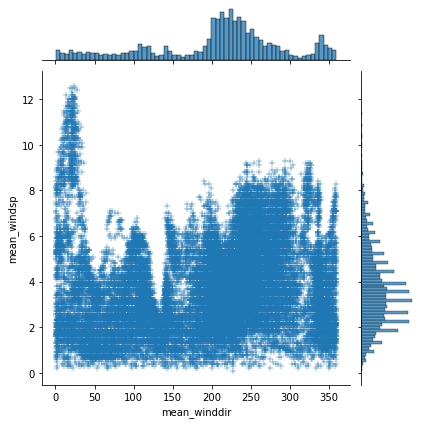

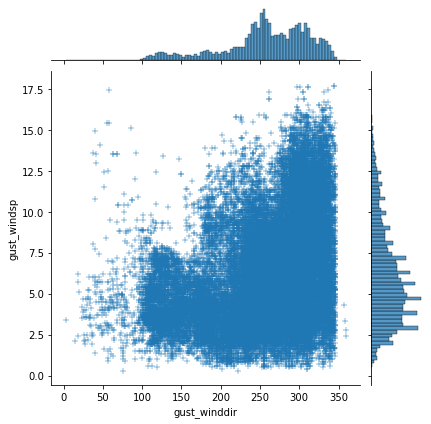

In [8]:
# Compute joint-probability

# Mean wind dir/sp
df_wind_mean=pd.DataFrame({'mean_windsp': wsp_mean1128, 'mean_winddir': wdir_mean1128})
sns.jointplot(data=df_wind_mean, x="mean_winddir", y="mean_windsp",marker="+")

# Gust wind dir/sp
df_wind_gust=pd.DataFrame({'gust_windsp': wsp_max1128, 'gust_winddir': wdir_max1128})
sns.jointplot(data=df_wind_gust, x="gust_winddir", y="gust_windsp",marker="+")

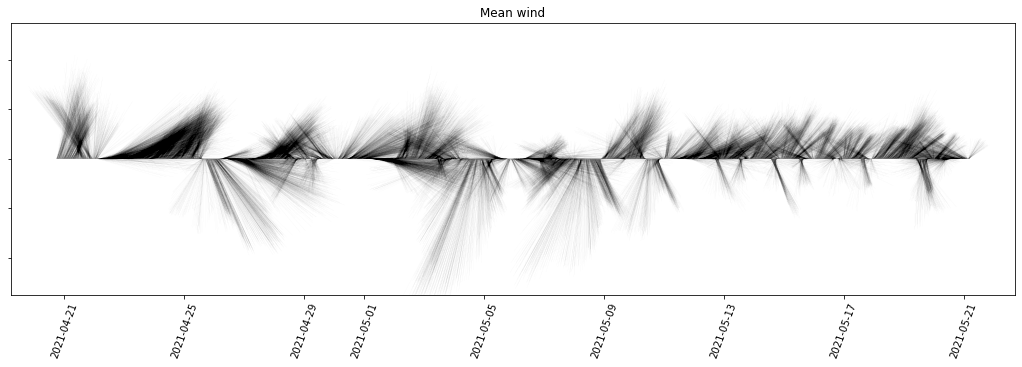

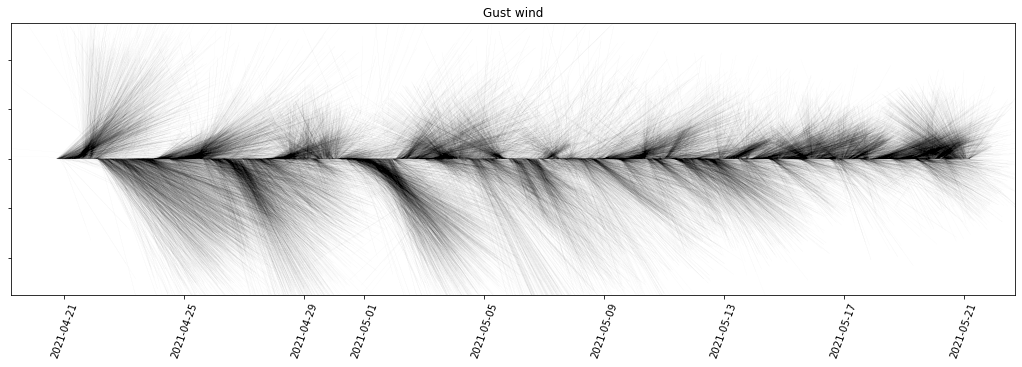

In [9]:
# Stick plots

# Calculate wind components from speed and metereological wind direction (wind from direction)
u_mean = -wsp_mean1128 * np.sin(np.radians(wdir_mean1128))
v_mean = -wsp_mean1128 * np.cos(np.radians(wdir_mean1128))

props = {'units' : "dots",
    'width' : 0.008,
    'headwidth': 0,
    'headlength': 0,
    'headaxislength': 0,
    'scale' : .08
        }
fig, ax = plt.subplots(figsize=(18, 5))
qiv = ax.quiver(time1128, [[0]*len(time1128)] , u_mean, v_mean, angles='uv', **props)
plt.xticks(rotation=70)
plt.setp(ax.get_yticklabels(), visible=False)
plt.title('Mean wind')

# Calculate wind components from speed and metereological wind direction (wind from direction)
u_max = -wsp_max1128 * np.sin(np.radians(wdir_max1128))
v_max = -wsp_max1128 * np.cos(np.radians(wdir_max1128))

props = {'units' : "dots",
    'width' : 0.008,
    'headwidth': 0,
    'headlength': 0,
    'headaxislength': 0,
    'scale' : .08
        }
fig, ax = plt.subplots(figsize=(18, 5))
qiv = ax.quiver(time1128, [[0]*len(time1128)] , u_max, v_max, angles='uv', **props)
plt.xticks(rotation=70)
plt.setp(ax.get_yticklabels(), visible=False)
plt.title('Gust wind');

In [10]:
# Read in mooring 1129A
ds_1129A = xr.open_dataset(fn2)
ds_1129A # Marconi data after met was transferred to its own pole
df_1129A=ds_1129A.to_dataframe() # Convert xarray dataset to pandas dataframe

# Make statistics table
df_1129A.describe()

,WD_min,WD_410,WD_gust,WS_min,WS_401,WG_402,T_21,RH_910
count,110792.000000,110792.000000,110792.000000,110792.000000,110792.000000,110792.000000,110792.000000,110792.000000
mean,149.156189,184.620422,225.418167,1.777684,3.647683,5.341212,21.057819,85.165840
std,83.071030,88.342041,82.048218,1.350469,1.967983,2.749400,3.098053,12.467874
min,0.390000,0.390000,4.390000,0.000000,0.000000,0.000000,11.400000,37.400002
25%,94.389999,126.389999,171.389999,0.900000,2.400000,3.400000,18.799999,76.199997
50%,159.389999,209.389999,252.389999,1.500000,3.400000,5.000000,20.700001,87.300003
75%,205.389999,242.389999,283.390015,2.200000,4.400000,6.700000,22.900000,96.199997
max,359.390015,359.390015,358.390015,12.900000,18.400000,25.100000,32.099998,100.000000


In [11]:
# Put 1129A variables into arrays
time1129A=ds_1129A['time'].values
wdir_min1129A=ds_1129A['WD_min'].values
wdir_mean1129A=ds_1129A['WD_410'].values
wdir_max1129A=ds_1129A['WD_gust'].values
wsp_min1129A=ds_1129A['WS_min'].values
wsp_mean1129A=ds_1129A['WS_401'].values
wsp_max1129A=ds_1129A['WG_402'].values
temp1129A=ds_1129A['T_21'].values
relh1129A=ds_1129A['RH_910'].values

Text(0, 0.5, 'Rel. humidity (%)')

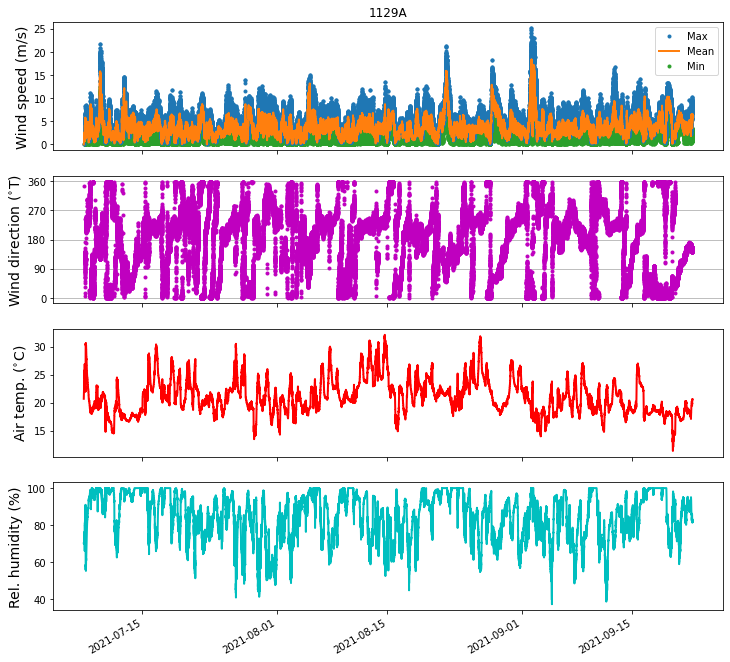

In [12]:
# 1129A Time-series plots
fig, ax=plt.subplots(nrows=4, ncols=1, sharey=False, sharex=True, squeeze=True, figsize = (12,12))

# Wind speed
ax[0].plot(time1129A,wsp_max1129A, '.',zorder=1,label='Max')
ax[0].plot(time1129A,wsp_mean1129A,'-',linewidth=2,zorder=2,label='Mean')
ax[0].plot(time1129A,wsp_min1129A, '.',zorder=0,label='Min')
ax[0].set_ylabel('Wind speed (m/s)',fontsize=14)
ax[0].legend()
ax[0].title.set_text('1129A')
fig.autofmt_xdate() # Rotate x-axis labels so you can read all of them
#ax[0].text(.02,.85,'Wind speed',fontsize=16,transform=ax[0].transAxes)

# Wind direction
ax[1].plot(time1129A,wdir_mean1129A,'m.',linewidth=2)
ax[1].set_yticks([0.,90.,180.,270,360])
ax[1].set_ylabel('Wind direction ($^{\circ}$T)',fontsize=14)
ax[1].grid(axis = 'y')
#ax[1].text(.02,.85,'Wind direction (from)',fontsize=16,transform=ax[1].transAxes)

# Temp
ax[2].plot(time1129A,temp1129A,'r-',linewidth=2)
ax[2].set_ylabel('Air temp. ($^{\circ}$C)',fontsize=14)
#ax[2].text(.02,.1,'Air temperature',fontsize=16,transform=ax[2].transAxes)

# Relative humidity
ax[3].plot(time1129A,relh1129A,'c-',linewidth=2)
ax[3].set_ylabel('Rel. humidity (%)',fontsize=14)
#ax[3].text(.02,.1,'Relative humidity',fontsize=16,transform=ax[4].transAxes)


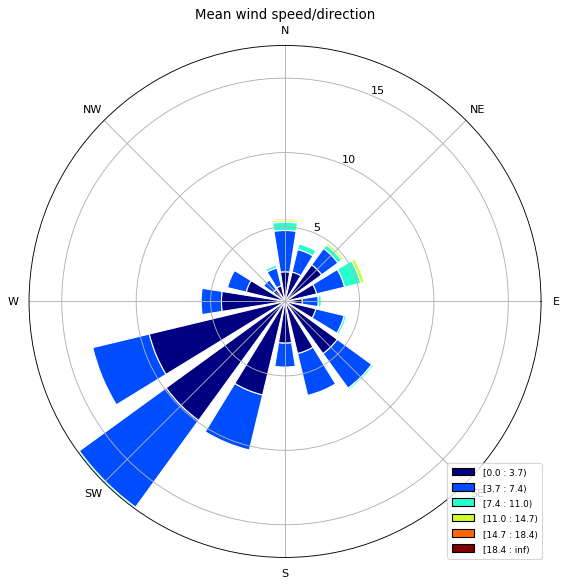

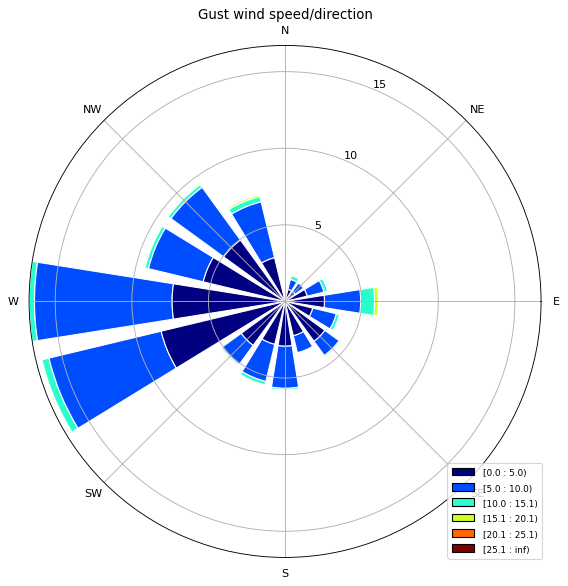

In [13]:
# 1129A Wind rose plot

# Mean wind dir/sp
ax=WindroseAxes.from_ax()
ax.bar(wdir_mean1129A, wsp_mean1129A, normed=True, opening=0.8, edgecolor='white')
ax.set_legend(loc=4)
plt.title('Mean wind speed/direction')
ax.set_yticks(np.arange(5, 20, step=5))
ax.set_yticklabels(np.arange(5, 20, step=5))
#ax.set_xticklabels((90, 45, 0, 315, 270, 225, 180, 135)) # Add this line bc there is an error in windrose axes
ax.set_xticklabels(['E', 'NE','N', 'NW', 'W', 'SW', 'S', 'SE']); # Add this line bc there is an error in windrose axes

# Gust wind dir/sp
ax=WindroseAxes.from_ax()
ax.bar(wdir_max1129A, wsp_max1129A, normed=True, opening=0.8, edgecolor='white')
ax.set_legend(loc=4)
plt.title('Gust wind speed/direction')
ax.set_yticks(np.arange(5, 20, step=5))
ax.set_yticklabels(np.arange(5, 20, step=5))
#ax.set_xticklabels((90, 45, 0, 315, 270, 225, 180, 135)) # Add this line bc there is an error in windrose axes
ax.set_xticklabels(['E', 'NE','N', 'NW', 'W', 'SW', 'S', 'SE']); # Add this line bc there is an error in windrose axes

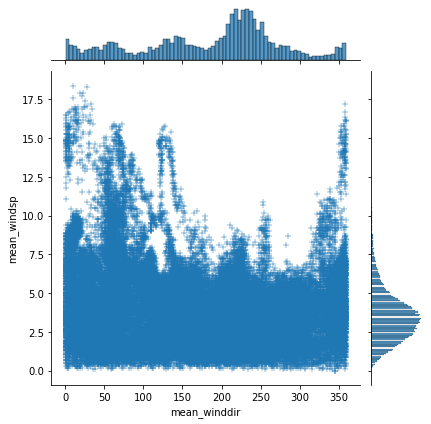

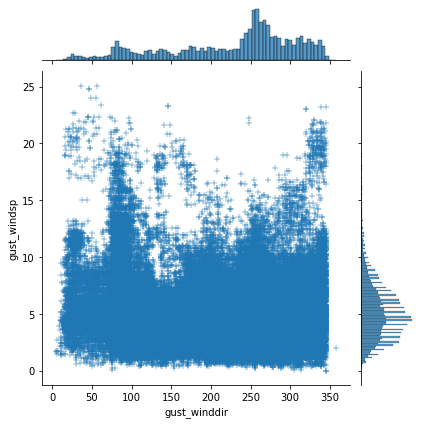

In [14]:
# Compute joint-probability

# Mean wind dir/sp
df_wind_mean=pd.DataFrame({'mean_windsp': wsp_mean1129A, 'mean_winddir': wdir_mean1129A})
sns.jointplot(data=df_wind_mean, x="mean_winddir", y="mean_windsp",marker="+")

# Gust wind dir/sp
df_wind_gust=pd.DataFrame({'gust_windsp': wsp_max1129A, 'gust_winddir': wdir_max1129A})
sns.jointplot(data=df_wind_gust, x="gust_winddir", y="gust_windsp",marker="+")

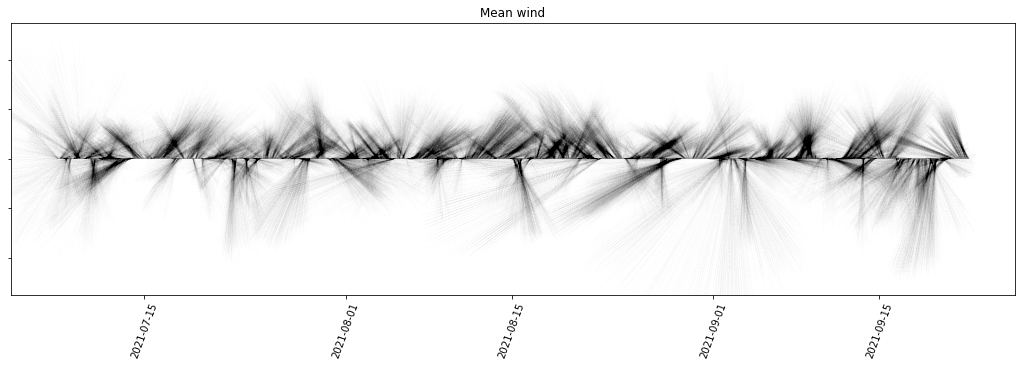

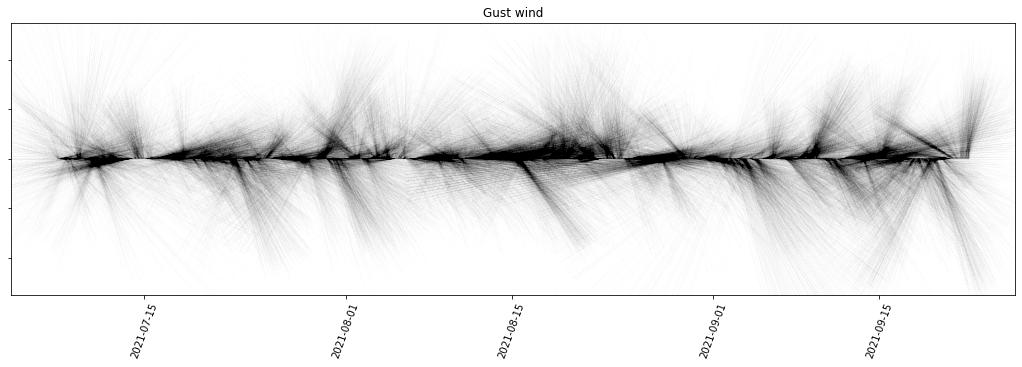

In [15]:
# Stick plots

# Calculate wind components from speed and metereological wind direction (wind from direction)
u_mean = -wsp_mean1129A * np.sin(np.radians(wdir_mean1129A))
v_mean = -wsp_mean1129A * np.cos(np.radians(wdir_mean1129A))

props = {'units' : "dots",
    'width' : 0.003,
    'headwidth': 0,
    'headlength': 0,
    'headaxislength': 0,
    'scale' : .08
        }
fig, ax = plt.subplots(figsize=(18, 5))
qiv = ax.quiver(time1129A, [[0]*len(time1129A)] , u_mean, v_mean, angles='uv', **props)
plt.xticks(rotation=70)
plt.setp(ax.get_yticklabels(), visible=False)
plt.title('Mean wind')

# Calculate wind components from speed and metereological wind direction (wind from direction)
u_max = -wsp_max1129A * np.sin(np.radians(wdir_max1129A))
v_max = -wsp_max1129A * np.cos(np.radians(wdir_max1129A))

props = {'units' : "dots",
    'width' : 0.003,
    'headwidth': 0,
    'headlength': 0,
    'headaxislength': 0,
    'scale' : .08
        }
fig, ax = plt.subplots(figsize=(18, 5))
qiv = ax.quiver(time1129A, [[0]*len(time1129A)] , u_max, v_max, angles='uv', **props)
plt.xticks(rotation=70)
plt.setp(ax.get_yticklabels(), visible=False)
plt.title('Gust wind');